<a href="https://colab.research.google.com/github/AnirbanChakraborty06/AnirbanChakraborty06/blob/main/ELOCustomerLoyalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ELO Customer Loyalty**

---



# Setting up PySpark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
!pip install pyspark

# Loading the data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c elo-merchant-category-recommendation

In [ ]:
!unzip historical_transactions.csv.zip
!unzip merchants.csv.zip
!unzip new_merchant_transactions.csv.zip
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import findspark
from pyspark import SparkContext, SparkConf
from pyspark import StorageLevel
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml import feature
from pyspark.ml import regression
from pyspark.ml import evaluation
from pyspark.ml import Pipeline,PipelineModel
from sklearn import linear_model
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import datetime

In [5]:
findspark.init()
conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled","true")

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')

In [7]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://7659-35-204-132-107.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://7659-35-204-132-107.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


# Utilities

In [8]:
def identify_null_cols(df, return_count=True,cols=None):
  '''
    Identifies the columns that have a null value.

    return_count: Determines if the count of null entries per column is also needed;
            default value is false.
    cols: Columns of a dataframe for which to do the check. List of columns to be provided as input;
          otherwise check is performed for all columns.
  '''
  if cols is None:
    cols = df.columns
  
  # get the column-wise count of null entries; 
  
  result = [(col,df.select(df[col].isNull().alias('colNull')).filter("colNull==true").count()) for col in cols]

  # prepare output based on return_count
  if return_count:
    result = [(r[0],'Yes',r[1]) if r[1] > 0 else (r[0],'No',r[1]) for r in result]
    return spark.createDataFrame(result,['Column names','Is null value present','No of null vales'])
  else:
    result = [(r[0],'Yes') if r[1] > 0 else (r[0],'No') for r in result]
    return spark.createDataFrame(result,['Column names','Is null value present'])

  

In [9]:
def check_duplicacy(df,cols=None):
  '''
    Check duplicacy in dataframe df, given group-by cols.
    cols: an iterable of strings denoting the column names of the dataframe.
          If None then it checks duplicate records (group by all columns).
  '''
  if cols is None:
    output = 'Group by --> all columns'
    cols = df.columns
  else:
    output = 'Group by --> ' + ', '.join(cols)

  is_duplicate_present = df.groupBy(cols).count().where('count > 1').count()
  
  if is_duplicate_present > 1:
    output += '|   Duplicates present'
  else:
    output += '|   Duplicates absent'
  
  return output

In [10]:
def updateViewAndCache(df,viewName=None,updateView=False,doCaching=True):
  '''
  Creates or replaces the temp view corresponding to dataframe df.
  Also caches df if required.

  The name of the temp view is viewName. If updateView is True
  viewName has to be set.
  '''
  if updateView:
    if isinstance(viewName,str):
      df.createOrReplaceTempView(viewName)
    else:
      raise ValueError('viewName is not a string')
  if doCaching:
    df.persist(StorageLevel.DISK_ONLY)
    df.count()

In [11]:
def combine_new_features(df, df_new, df_new_cols=None, key_cols = ['card_id'], df_cols = ['card_id','target']):
  '''
      This method combines dataframes df and df_new using column key_cols.
      The columns df_cols and df_new_cols are selected from df and df_new respectively
      to produce the merged dataframe, df_merged, that will be returned.
  '''
  if df_new_cols is None:
    df_new_cols = [col for col in df_new.columns if col not in df_cols]
  else:
    df_new_cols = [col for col in df_new_cols if col not in df_cols]
    
  return df.join(df_new, key_cols).select(df_cols+df_new_cols)

In [12]:
def fit_evaluator_random_regressor(df,inputCols,labelCol):
  '''
  A RandomForest regressor to fit the data and return the R2 score. 
  
  This is a very basic utility to make gross observations only and should not be used
  to make subtle decisions regarding feature importance.
  '''
  vectorAssembler = feature.VectorAssembler(inputCols=inputCols,outputCol='features')
  randomForestRegressor = regression.RandomForestRegressor(featuresCol='features',labelCol=labelCol)
  pipeline = Pipeline(stages=[vectorAssembler,randomForestRegressor])
  pipelinemodel = pipeline.fit(df)
  r2Score = evaluation.RegressionEvaluator(labelCol='target',metricName='r2').evaluate(pipelinemodel.transform(df))
  return round(r2Score,4)

In [13]:
def label_encoder(df, inputCols, outputCols=None, handleInvalid='error', stringOrderType='alphabetAsc'):
  '''
    This methods takes a dataframe and a list of its columns - inputCols - as input.
    Returns the transformer and transformed dataframe.
    The inputCols are transformed via StringIndexer.
  '''
  if outputCols is None:
    outputCols = [col+'Enc' for col in inputCols]
  
  indexer = feature.StringIndexer(inputCols=inputCols,outputCols=outputCols,handleInvalid=handleInvalid, stringOrderType=stringOrderType)
  model = indexer.fit(df)
  df_encoded = model.transform(df).drop(*inputCols)

  return(df_encoded,model)

In [14]:
# Taken from https://www.kaggle.com/fabiendaniel/elo-world

def reduce_mem_usage(df, verbose=True):
  '''
    An utility to reduce the memory of pandas dataframes by converting the columns 
    of numeric datatypes to lower sizes without losing any information, 
    based on the range of values in the column.
  '''

  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [15]:
def convert_to_pandas(sdf, reduce_memory = True, verbose=True):
  '''
    Converts a spark dataframe sdf to pandas dataframe;
    optionally reduces the memory usage of the pandas
    dataframe before returing it. 
    
    verbose - decides if additional memory reduction logging
    is necessary.
  '''

  pdf = sdf.toPandas()

  if reduce_memory:
    return reduce_mem_usage(pdf, verbose)
  
  return pdf

In [16]:
def pandas_random_forest_regr(pdf, excl_cols=['card_id'], target='target', num_of_folds=5, scoring_metric='neg_mean_squared_error'):
  '''
      Takes in a pandas dataframe pdf and fits a random forest regressor to
      it using K-fold cross-validation.

      It returns the list of cross-validation scores.

      excl_cols: ignore the columns in excl_cols that are in pdf
      target: column in pdf to use a target
              features = pdf.columns - excl_cols - target
      num_of_folds: no of folds to use for K-fold cross-validation
      scoring_metric: metric to use in cross-validation scoring
  '''
  non_feature_cols = excl_cols+[target]
  feature_cols = [col for col in pdf.columns if col not in non_feature_cols]

  X,y = pdf[feature_cols], pdf[target]

  random_forest_regressor = ensemble.RandomForestRegressor()
  cvfolds = model_selection.KFold(n_splits=num_of_folds)

  return model_selection.cross_val_score(estimator=random_forest_regressor,X=X,y=y,cv=cvfolds,scoring=scoring_metric, verbose=3)

# Load the files

## history transactions

In [17]:
histTxnSchema = StructType(list((
StructField('authorized_flag',StringType()),
StructField('card_id',StringType()),
StructField('city_id',IntegerType()),
StructField('category_1',StringType()),
StructField('installments',IntegerType()),
StructField('category_3',StringType()),
StructField('merchant_category_id',IntegerType()),
StructField('merchant_id',StringType()),
StructField('month_lag',IntegerType()),
StructField('purchase_amount',DoubleType()),
StructField('purchase_date',TimestampType()),
StructField('category_2',DoubleType()),
StructField('state_id',IntegerType()),
StructField('subsector_id',IntegerType())
)))
histTxns = spark.read.csv('historical_transactions.csv',header=True,schema=histTxnSchema)
updateViewAndCache(histTxns,viewName='histTxnsView',updateView=True,doCaching=False)
histTxns.show(5)

+---------------+---------------+-------+----------+------------+----------+--------------------+---------------+---------+---------------+-------------------+----------+--------+------------+
|authorized_flag|        card_id|city_id|category_1|installments|category_3|merchant_category_id|    merchant_id|month_lag|purchase_amount|      purchase_date|category_2|state_id|subsector_id|
+---------------+---------------+-------+----------+------------+----------+--------------------+---------------+---------+---------------+-------------------+----------+--------+------------+
|              Y|C_ID_4e6213e9bc|     88|         N|           0|         A|                  80|M_ID_e020e9b302|       -8|    -0.70333091|2017-06-25 15:33:07|       1.0|      16|          37|
|              Y|C_ID_4e6213e9bc|     88|         N|           0|         A|                 367|M_ID_86ec983688|       -7|    -0.73312848|2017-07-15 12:10:45|       1.0|      16|          16|
|              Y|C_ID_4e6213e9bc|  

In [ ]:
histTxns.summary().show()

+-------+---------------+---------------+------------------+----------+------------------+----------+--------------------+---------------+------------------+-------------------+------------------+------------------+------------------+
|summary|authorized_flag|        card_id|           city_id|category_1|      installments|category_3|merchant_category_id|    merchant_id|         month_lag|    purchase_amount|        category_2|          state_id|      subsector_id|
+-------+---------------+---------------+------------------+----------+------------------+----------+--------------------+---------------+------------------+-------------------+------------------+------------------+------------------+
|  count|       29112361|       29112361|          29112361|  29112361|          29112361|  28934202|            29112361|       28973880|          29112361|           29112361|          26459497|          29112361|          29112361|
|   mean|           null|           null|129.32561659976668|

## new merchant transactions

In [18]:
newTxns = spark.read.csv('new_merchant_transactions.csv',header=True,schema=histTxnSchema)
updateViewAndCache(newTxns,viewName='newTxnsView',updateView=True,doCaching=False)
newTxns.show(5)

+---------------+---------------+-------+----------+------------+----------+--------------------+---------------+---------+---------------+-------------------+----------+--------+------------+
|authorized_flag|        card_id|city_id|category_1|installments|category_3|merchant_category_id|    merchant_id|month_lag|purchase_amount|      purchase_date|category_2|state_id|subsector_id|
+---------------+---------------+-------+----------+------------+----------+--------------------+---------------+---------+---------------+-------------------+----------+--------+------------+
|              Y|C_ID_415bb3a509|    107|         N|           1|         B|                 307|M_ID_b0c793002c|        1|    -0.55757375|2018-03-11 14:57:36|       1.0|       9|          19|
|              Y|C_ID_415bb3a509|    140|         N|           1|         B|                 307|M_ID_88920c89e8|        1|    -0.56957993|2018-03-19 18:53:37|       1.0|       9|          19|
|              Y|C_ID_415bb3a509|  

In [ ]:
newTxns.summary().show()

+-------+---------------+---------------+------------------+----------+-----------------+----------+--------------------+---------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|authorized_flag|        card_id|           city_id|category_1|     installments|category_3|merchant_category_id|    merchant_id|          month_lag|    purchase_amount|        category_2|          state_id|      subsector_id|
+-------+---------------+---------------+------------------+----------+-----------------+----------+--------------------+---------------+-------------------+-------------------+------------------+------------------+------------------+
|  count|        1963031|        1963031|           1963031|   1963031|          1963031|   1907109|             1963031|        1936815|            1963031|            1963031|           1851286|           1963031|           1963031|
|   mean|           null|           null|134.38667906925565|

## train

In [19]:
trainSchema = StructType(
    [
     StructField('first_active_month',DateType()),
     StructField('card_id',StringType()),
     StructField('feature_1',IntegerType()),
     StructField('feature_2',IntegerType()),
     StructField('feature_3',IntegerType()),
     StructField('target',FloatType())
    ]
)
train = spark.read.csv('train.csv',header=True,schema=trainSchema)
updateViewAndCache(train,viewName='trainView',updateView=True,doCaching=False)
train.show(5)

+------------------+---------------+---------+---------+---------+----------+
|first_active_month|        card_id|feature_1|feature_2|feature_3|    target|
+------------------+---------------+---------+---------+---------+----------+
|        2017-06-01|C_ID_92a2005557|        5|        2|        1|-0.8202826|
|        2017-01-01|C_ID_3d0044924f|        4|        1|        0|0.39291325|
|        2016-08-01|C_ID_d639edf6cd|        2|        2|        0|  0.688056|
|        2017-09-01|C_ID_186d6a6901|        4|        3|        0| 0.1424952|
|        2017-11-01|C_ID_cdbd2c0db2|        1|        3|        0|-0.1597492|
+------------------+---------------+---------+---------+---------+----------+
only showing top 5 rows



## test

In [20]:
testSchema = StructType(
    [
     StructField('first_active_month',DateType()),
     StructField('card_id',StringType()),
     StructField('feature_1',IntegerType()),
     StructField('feature_2',IntegerType()),
     StructField('feature_3',IntegerType())
    ]
)
test = spark.read.csv('test.csv',header=True,schema=testSchema)
updateViewAndCache(test,viewName='testView',updateView=True,doCaching=False)
test.show(5)

+------------------+---------------+---------+---------+---------+
|first_active_month|        card_id|feature_1|feature_2|feature_3|
+------------------+---------------+---------+---------+---------+
|        2017-04-01|C_ID_0ab67a22ab|        3|        3|        1|
|        2017-01-01|C_ID_130fd0cbdd|        2|        3|        0|
|        2017-08-01|C_ID_b709037bc5|        5|        1|        1|
|        2017-12-01|C_ID_d27d835a9f|        2|        1|        0|
|        2015-12-01|C_ID_2b5e3df5c2|        5|        1|        1|
+------------------+---------------+---------+---------+---------+
only showing top 5 rows



## merchants

In [21]:
merchantSchema = StructType(
    [
     StructField('merchant_id',StringType()),
     StructField('merchant_group_id',IntegerType()),
     StructField('merchant_category_id',IntegerType()),
     StructField('subsector_id',IntegerType()),
     StructField('numerical_1',FloatType()),
     StructField('numerical_2',FloatType()),
     StructField('category_1',StringType()),
     StructField('most_recent_sales_range',StringType()),
     StructField('most_recent_purchases_range',StringType()),
     StructField('avg_sales_lag3',FloatType()),
     StructField('avg_purchases_lag3',FloatType()),
     StructField('active_months_lag3',IntegerType()),
     StructField('avg_sales_lag6',FloatType()),
     StructField('avg_purchases_lag6',FloatType()),
     StructField('active_months_lag6',IntegerType()),
     StructField('avg_sales_lag12',FloatType()),
     StructField('avg_purchases_lag12',FloatType()),
     StructField('active_months_lag12',IntegerType()),
     StructField('category_4',StringType()),
     StructField('city_id',IntegerType()),
     StructField('state_id',IntegerType()),
     StructField('category_2',FloatType()),
    ]
)
merchant = spark.read.csv('merchants.csv',header=True,schema=merchantSchema)
updateViewAndCache(merchant,viewName='merchantView',updateView=True,doCaching=False)
merchant.show(5)

+---------------+-----------------+--------------------+------------+-----------+-----------+----------+-----------------------+---------------------------+--------------+------------------+------------------+--------------+------------------+------------------+---------------+-------------------+-------------------+----------+-------+--------+----------+
|    merchant_id|merchant_group_id|merchant_category_id|subsector_id|numerical_1|numerical_2|category_1|most_recent_sales_range|most_recent_purchases_range|avg_sales_lag3|avg_purchases_lag3|active_months_lag3|avg_sales_lag6|avg_purchases_lag6|active_months_lag6|avg_sales_lag12|avg_purchases_lag12|active_months_lag12|category_4|city_id|state_id|category_2|
+---------------+-----------------+--------------------+------------+-----------+-----------+----------+-----------------------+---------------------------+--------------+------------------+------------------+--------------+------------------+------------------+---------------+------

## Are the 3 features from train.csv enough?

We will want to know if the three features - feature_1, feature_2 and feature_3 - are good enough to predict target (the loyalty score). Towards that end, we will fit a RandomForestRegressor to the entire training set and see if it is at all a good fit. We will check the $R^2$ score as our measure of goodness of fit.

In [ ]:
# vectorAssembler = feature.VectorAssembler(inputCols=['feature_1','feature_2','feature_3'],outputCol='features')
# randomForestRegressor = regression.RandomForestRegressor(featuresCol='features',labelCol='target')
# pipeline = Pipeline(stages=[vectorAssembler,randomForestRegressor])
# pipelinemodel = pipeline.fit(train)
# r2Score = evaluation.RegressionEvaluator(labelCol='target',metricName='r2').evaluate(pipelinemodel.transform(train))
# print(f'R2 score of fitting a random forest to the entire training set using feature_1, feature_2 and feature_3 is {np.around(r2Score,4)}')

The $R^2$ score being too small makes it clear that these 3 features will not be of much use. So now our aim will be to find new features given the transaction data of the card_ids.

# Finding other features



## Sanity checks

We will create a dataframe that will have additional features for each card_id derived from the transactions and merchant data. Once we have derived the features we will merge this dataframe with the train and test dataframes.

Towards some sanity checks are required -

1. Are there any card_ids in train or test without corresponding transaction level data in historical transactions? - they might need to be removed.
2. Are there any columns with null entries in train, test, histTxns, newTxns and merchant? - if card_id/merchant_id is null then that entry should be removed.
3. Are there any duplicate card_id entries is train or test? - duplicacy needs to be handled.
4. Are there duplicate entries in histTxns, newTxns and merchant? - duplicate entries can be removed.
5. Are there any card_ids in histTxns and newTxns which are not present in either train or test? - will help in deciding which set of tables to use for preparing the overall set of card_ids for which to generate new features based on transaction data.



### Check 1

In [ ]:
train.select('card_id').union(test.select('card_id')).subtract(histTxns.select('card_id')).count()

0

### Check 2

In [ ]:
identify_null_cols(train).show()

+------------------+---------------------+----------------+
|      Column names|Is null value present|No of null vales|
+------------------+---------------------+----------------+
|first_active_month|                   No|               0|
|           card_id|                   No|               0|
|         feature_1|                   No|               0|
|         feature_2|                   No|               0|
|         feature_3|                   No|               0|
|            target|                   No|               0|
+------------------+---------------------+----------------+



In [ ]:
identify_null_cols(test).show()

+------------------+---------------------+----------------+
|      Column names|Is null value present|No of null vales|
+------------------+---------------------+----------------+
|first_active_month|                  Yes|               1|
|           card_id|                   No|               0|
|         feature_1|                   No|               0|
|         feature_2|                   No|               0|
|         feature_3|                   No|               0|
+------------------+---------------------+----------------+



In [ ]:
identify_null_cols(histTxns).show()

+--------------------+---------------------+----------------+
|        Column names|Is null value present|No of null vales|
+--------------------+---------------------+----------------+
|     authorized_flag|                   No|               0|
|             card_id|                   No|               0|
|             city_id|                   No|               0|
|          category_1|                   No|               0|
|        installments|                   No|               0|
|          category_3|                  Yes|          178159|
|merchant_category_id|                   No|               0|
|         merchant_id|                  Yes|          138481|
|           month_lag|                   No|               0|
|     purchase_amount|                   No|               0|
|       purchase_date|                   No|               0|
|          category_2|                  Yes|         2652864|
|            state_id|                   No|               0|
|       

In [ ]:
identify_null_cols(newTxns).show()

+--------------------+---------------------+----------------+
|        Column names|Is null value present|No of null vales|
+--------------------+---------------------+----------------+
|     authorized_flag|                   No|               0|
|             card_id|                   No|               0|
|             city_id|                   No|               0|
|          category_1|                   No|               0|
|        installments|                   No|               0|
|          category_3|                  Yes|           55922|
|merchant_category_id|                   No|               0|
|         merchant_id|                  Yes|           26216|
|           month_lag|                   No|               0|
|     purchase_amount|                   No|               0|
|       purchase_date|                   No|               0|
|          category_2|                  Yes|          111745|
|            state_id|                   No|               0|
|       

In [ ]:
identify_null_cols(merchant).show(30)

+--------------------+---------------------+----------------+
|        Column names|Is null value present|No of null vales|
+--------------------+---------------------+----------------+
|         merchant_id|                   No|               0|
|   merchant_group_id|                   No|               0|
|merchant_category_id|                   No|               0|
|        subsector_id|                   No|               0|
|         numerical_1|                   No|               0|
|         numerical_2|                   No|               0|
|          category_1|                   No|               0|
|most_recent_sales...|                   No|               0|
|most_recent_purch...|                   No|               0|
|      avg_sales_lag3|                  Yes|              13|
|  avg_purchases_lag3|                  Yes|               3|
|  active_months_lag3|                   No|               0|
|      avg_sales_lag6|                  Yes|              13|
|  avg_p

### Check 3

In [ ]:
check_duplicacy(train,cols=['card_id'])

'Group by --> card_id|   Duplicates absent'

In [ ]:
check_duplicacy(test,cols=['card_id'])

'Group by --> card_id|   Duplicates absent'

### Check 4

In [ ]:
for name,df in zip(['histTxns','newTxns','merchant'], [histTxns,newTxns,merchant]):
  print(name)
  print('==================')
  print(check_duplicacy(df)+'\n\n')

histTxns
Group by --> all columns|   Duplicates absent


newTxns
Group by --> all columns|   Duplicates absent


merchant
Group by --> all columns|   Duplicates absent




### Check 5

In [ ]:
histTxns.select('card_id').union(newTxns.select('card_id')).subtract(train.select('card_id').union(test.select('card_id'))).count()

0

1.   Hence there are no card_ids in train and test without corresponding data in historical transactions.
2.   There are no null values in train. test has null value in first_active_month, not card_id; hence can be taken care of under null value imputation. Similarly for histTxns, newTxns and merchant the null values are in no such columns that require the entries to be removed right away.
3. There are no card_ids in train or test with multiple entries.
4. There are no duplicate entries in histTxns, newTxns and merchant.
5. There are no card_ids in histTxns and newTxns that is not present in train or test.



## Dataframe for new features

We will create the dataframe **new_features** which is supposed to hold the new features for each card_id

In [22]:
new_features = train.select('card_id').union(test.select('card_id')).distinct()
new_features.show(5)

+---------------+
|        card_id|
+---------------+
|C_ID_f63f5a6a60|
|C_ID_21d034c8f7|
|C_ID_5cd26d0ad2|
|C_ID_bbc9271d4d|
|C_ID_7cff9a4ea0|
+---------------+
only showing top 5 rows



In [23]:
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
new_features.count()

325540

## Transaction count 

#### Sanity checks



1.   Does the authorized_flag column only contain Y and N? - this column will be used to determine the count of authorized and unauthorized transactions respectively.



In [ ]:
histTxns.select('authorized_flag').distinct().show()

+---------------+
|authorized_flag|
+---------------+
|              Y|
|              N|
+---------------+



**Sanity check results**
1. authorized_flag only has Y and N

### histAuthTxnsCount

No of authorised transactions for a card_id in histTxns

In [24]:
new_features = spark.sql('''
select
t3.*, NVL(t2.histAuthTxnsCount,0) as histAuthTxnsCount
from

new_features_view t3

LEFT JOIN 
          (
            SELECT t1.card_id, COUNT(1) AS histAuthTxnsCount FROM histTxnsView t1 where t1.authorized_flag = 'Y' GROUP BY t1.card_id
          ) t2
ON t3.card_id = t2.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
'''
vectorAssembler = feature.VectorAssembler(inputCols=['feature_1','feature_2','feature_3','histAuthTxnsCount'],outputCol='features')
randomForestRegressor = regression.RandomForestRegressor(featuresCol='features',labelCol='target')
pipeline = Pipeline(stages=[vectorAssembler,randomForestRegressor])
pipelinemodel = pipeline.fit(train)
r2Score = evaluation.RegressionEvaluator(labelCol='target',metricName='r2').evaluate(pipelinemodel.transform(train))
print(f'R2 score of fitting a random forest now with histTxnsCount is {round(r2Score,4)}')
'''

Because the R2 score increases we believe that this approach of adding additional features for each crad_id given their transactions will be useful to better predict the loyalty score. This is what "personalizing the user experience" is all about.

### histUnauthTxnCount

No of unauthorised transactions for a card_id in histTxns.

In [25]:
new_features = spark.sql('''
select
t3.*, NVL(t2.histUnauthTxnCount,0) as histUnauthTxnCount
from
new_features_view t3
LEFT JOIN 
          (
            SELECT t1.card_id, COUNT(1) AS histUnauthTxnCount FROM histTxnsView t1 
            WHERE t1.authorized_flag = 'N'
            GROUP BY t1.card_id
          ) t2
ON t3.card_id = t2.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

## Purchase amount

histTxns contains no null values in purchase amount column.

### histAvgAuthPurchaseAmt, histStdevAuthPurchaseAmt

Average purchase amount for each card over a period of 3 months

Because we want to study the purchase amounts without them being correlated to the number of transactions it is better to study the average purchase amount. Because the total number of authorised transactions are already being tracked as a feature, no information loss should be there for keeping average instead of total amount.

In [26]:
new_features = spark.sql('''
select
t3.*, NVL(t2.histAvgAuthPurchaseAmt,0) as histAvgAuthPurchaseAmt, NVL(t2.histStdevAuthPurchaseAmt,0) as histStdevAuthPurchaseAmt
from
new_features_view t3
LEFT JOIN 
          (
            SELECT t1.card_id, avg(t1.purchase_amount) AS histAvgAuthPurchaseAmt, stddev(t1.purchase_amount) as histStdevAuthPurchaseAmt FROM histTxnsView t1 
            WHERE t1.authorized_flag = 'Y'
            GROUP BY t1.card_id
          ) t2
ON t3.card_id = t2.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

### histAvgUnauthPurchaseAmt, histStdevUnauthPurchaseAmt

Average purchase amount over unauthorised transactions for each card in histTxns

In [27]:
new_features = spark.sql('''
select
t3.*, NVL(t2.histAvgUnauthPurchaseAmt,0) as histAvgUnauthPurchaseAmt, NVL(t2.histStdevUnauthPurchaseAmt,0) as histStdevUnauthPurchaseAmt
from
new_features_view t3
LEFT JOIN 
          (
            SELECT t1.card_id, avg(t1.purchase_amount) AS histAvgUnauthPurchaseAmt, stddev(t1.purchase_amount) as histStdevUnauthPurchaseAmt FROM histTxnsView t1 
            WHERE t1.authorized_flag = 'N'
            GROUP BY t1.card_id
          ) t2
ON t3.card_id = t2.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

## City

There are no null values in city_id column.

In [ ]:
histTxns.select('city_id').describe().show()

+-------+------------------+
|summary|           city_id|
+-------+------------------+
|  count|          29112361|
|   mean|129.32561659976668|
| stddev|104.25630137841988|
|    min|                -1|
|    max|               347|
+-------+------------------+



### histTotCityCount
No of different city_ids associated with each card_id in histTxnsView.

In [ ]:
spark.sql('''
            select t2.card_id from
              (select distinct t1.card_id,t1.city_id from histTxnsView t1) t2
            group by t2.card_id
            having count(1) > 1    
'''
).count()

301375

There are lots of card_ids with number of distinct associated city_ids more than 1. So it might indicate towards some sort of parameter like number of different cities from which the card was used. Therefore this feature seems worth including.

In [28]:
new_features = spark.sql('''
  select
  t3.*, t2.histTotCityCount
  from
  new_features_view t3
  left join 
            (
              select t1.card_id, count(distinct t1.city_id) as histTotCityCount from
              histTxnsView t1
              group by t1.card_id
            ) t2
  on t3.card_id = t2.card_id
'''
)
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
histTxns.select(F.countDistinct(histTxns.city_id).alias('No_of_distinct_city_ids')).show()

+-----------------------+
|No_of_distinct_city_ids|
+-----------------------+
|                    308|
+-----------------------+



The number of different cities is too large to introduce a column for each city.

In [ ]:
cityCntPerCardDF = spark.sql('''
          select 
          t.card_id,
          count(distinct t.city_id) as cityCntPerCard

          from 
          histTxnsView t

          group by t.card_id
''').toPandas()

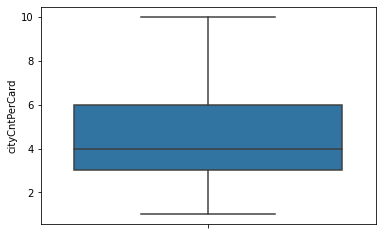

In [ ]:
sns.boxplot(y='cityCntPerCard', data=cityCntPerCardDF, showfliers=False);

However the count of different cities per card, from the above distribution plot, seems manageable. It seems we should include the most frequent 4 cities for each card_id.

### histFrequentCity1, histFrequentCity2, histFrequentCity3, histFrequentCity4

Most frequently occuring 4 cities for each card_id.

In [29]:
new_features = spark.sql('''
          with top3FrequentCitiesPerCard(card_id,city_id,rank,proportionOfTxns) as (
            select
            t2.card_id,
            t2.city_id,
            t2.rank,
            t2.proportionOfTxns
            from
            (
                  select
                  t1.card_id,
                  t1.city_id,
                  row_number() over (partition by t1.card_id order by t1.cntPerCardAndCity desc) as rank,
                  t1.cntPerCardAndCity/sum(t1.cntPerCardAndCity) over (partition by t1.card_id) as proportionOfTxns
                  from
                  (
                        select
                        t.card_id,
                        t.city_id,
                        count(*) as cntPerCardAndCity 
                        from
                        histTxnsView t
                        group by t.card_id,t.city_id
                  ) t1
            ) t2
            where t2.rank <= 4
          )

          select
          new_features_view.*,
          t_first.city_id as histFrequentCity1,
          nvl(t_first.proportionOfTxns,0) as histFrequentCity1Prop,
          t_second.city_id as histFrequentCity2,
          nvl(t_second.proportionOfTxns,0) as histFrequentCity2Prop,
          t_third.city_id as histFrequentCity3,
          nvl(t_third.proportionOfTxns,0) as histFrequentCity3Prop,
          t_fourth.city_id as histFrequentCity4,
          nvl(t_fourth.proportionOfTxns,0) as histFrequentCity4Prop

          from
          new_features_view

          left join (select * from top3FrequentCitiesPerCard where rank = 1) t_first on new_features_view.card_id = t_first.card_id
          left join (select * from top3FrequentCitiesPerCard where rank = 2) t_second on new_features_view.card_id = t_second.card_id
          left join (select * from top3FrequentCitiesPerCard where rank = 3) t_third on new_features_view.card_id = t_third.card_id
          left join (select * from top3FrequentCitiesPerCard where rank = 4) t_fourth on new_features_view.card_id = t_fourth.card_id

''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
new_features.filter('''
histFrequentCity1 is NULL
OR histFrequentCity2 is NULL
OR histFrequentCity3 is NULL
OR histFrequentCity4 is NULL
''').count()

130915

### histFrequentCity1Enc, histFrequentCity2Enc, histFrequentCity3Enc, histFrequentCity4Enc


#### Label encoding and null imputation

There are card_ids which do not have 4 distinct city_ids in histTxns. We would need to modify the 4 categorical columns for the 4 most frequent city_ids - 

*   Replacing the nulls with a different id altogether - let null values be denoted by city_id 9999.
*   Label encoding - as we plan to use non-linear models.




In [30]:
new_features = new_features.fillna(value=9999, subset=('histFrequentCity1','histFrequentCity2','histFrequentCity3','histFrequentCity4'))
new_features, city_encoder = label_encoder(new_features,inputCols=['histFrequentCity1','histFrequentCity2','histFrequentCity3','histFrequentCity4'])
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

## category_1
category_1 values for the card_ids. 

There are no null values in category_1 in histTxns. We will check the distinct types of category_1 values in histTxns first.

In [ ]:
histTxns.select('category_1').distinct().show()

+----------+
|category_1|
+----------+
|         Y|
|         N|
+----------+



It is either Y or N. Now we will confirm if there are card_ids for which there is more than one category_1 value for each card_id.

In [ ]:
spark.sql('''
          select
            t.card_id,
            count(distinct t.category_1) as cnt
          from
            histTxnsView t
          group by t.card_id
          having cnt > 1
'''
).count()

143715

There are card_ids that have more than one distinct value for category_1. Hence we would like to know the following - 


*   if a card_id has (only Y)/(only N)/(both Y and N)
*   for card_ids with both Y and N what is the proportion of both

One way to get all this data captured in one feature is to study the proportion of Y in the number of transactions for each card_id.

*   for card_ids with only N this will be 0
*   for card_ids with both Y and N this will be (0,1)
*   for card_ids with only Y this will be 1

In [ ]:
spark.sql('''
          select
            t1.*,
            round(t1.CNT/sum(t1.CNT) over (partition by t1.authorized_flag),3) as proportion
          from
            (
              select 
                t.authorized_flag,
                t.category_1,
                count(1) as CNT
              from 
                histTxnsView t 
              group by t.authorized_flag,t.category_1
            ) t1
          order by t1.authorized_flag, t1.CNT desc
''').show()

+---------------+----------+--------+----------+
|authorized_flag|category_1|     CNT|proportion|
+---------------+----------+--------+----------+
|              N|         N| 1992939|     0.792|
|              N|         Y|  523970|     0.208|
|              Y|         N|25035393|     0.941|
|              Y|         Y| 1560059|     0.059|
+---------------+----------+--------+----------+



For unauthorised transactions the proportion of category_1 classes - Y and N, are closer than that for authorised transactions. Hence for evaluating the proportion of category_1=Y transactions for each card_id we do not distinguish between authorised and unauthorised transactions.

### histCategory1YProp
Proportion of Y in category_1 for each card_id in histTxns.

In [31]:
new_features = spark.sql('''

          select          
          t3.*, nvl(t2.YCount,0)/(t3.histAuthTxnsCount + t3.histUnauthTxnCount) as histCategory1YProp
          from         
          new_features_view t3
          left join
              (select t1.card_id, count(1) as YCount from histTxnsView t1 where t1.category_1='Y' group by t1.card_id) t2
          on t3.card_id = t2.card_id
'''
)

updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

## Installments

There are no null values in installments in histTxns. We will check the distinct values of installments

In [ ]:
histTxns.select('installments').distinct().count()

15

We will want to check what the count-wise distribution of transactions over installment values are.

In [ ]:
spark.sql('select t.installments, count(1) from histTxnsView t group by t.installments order by t.installments').show()

+------------+--------+
|installments|count(1)|
+------------+--------+
|          -1|  178159|
|           0|15411747|
|           1|11677522|
|           2|  666416|
|           3|  538207|
|           4|  179525|
|           5|  116090|
|           6|  132634|
|           7|   10906|
|           8|   20474|
|           9|    5772|
|          10|  118827|
|          11|     830|
|          12|   55064|
|         999|     188|
+------------+--------+



The values -1, 1, 0 and 999 are confusing regarding their interpretations. Hence let's investigate them further in relation to other features like authorisation_flag.

In [ ]:
spark.sql(
    '''
          select 
          t1.installments,t1.authorized_flag,count(1) as CNT
          from
          histTxnsView t1
          where
          t1.installments in (-1,0,1,999)
          group by t1.installments,t1.authorized_flag
          order by t1.installments,t1.authorized_flag
'''
).show()

+------------+---------------+--------+
|installments|authorized_flag|     CNT|
+------------+---------------+--------+
|          -1|              N|   20365|
|          -1|              Y|  157794|
|           0|              N| 1109158|
|           0|              Y|14302589|
|           1|              N| 1085735|
|           1|              Y|10591787|
|         999|              N|     182|
|         999|              Y|       6|
+------------+---------------+--------+



From the above counts it is clear that almost all 999 installment cases are unauthorised transactions. Hence they should be ignored as error cases. For -1, 0 and 1 installment though the number of authorised transactions are almost an order larger than the number of unauthorised ones; hence cases with such installment values cannot be ignored as similar error cases.

The number of transactions with -1 installments and authorised_flag as Y is comparable and often larger than the number of transactions with ordinary installment numbers like 4, 5, 6 etc. Hence it cannot be readily ignored.

Let us investigate the average purchase amount for authorised transactions with -1, 0 or 1 installment. Our expectation is that greater purchase amounts often have larger installment numbers.

In [ ]:
spark.sql('''
          select
          t1.installments,
          avg(t1.purchase_amount) as avgPurchaseAmt
          
          from 
          histTxnsView t1 
          
          where 
          t1.installments >= -1
          and t1.installments <= 12
          and t1.authorized_flag = 'Y'

          group by t1.installments

          order by avgPurchaseAmt
''').show()

+------------+--------------------+
|installments|      avgPurchaseAmt|
+------------+--------------------+
|           0| -0.6411676746839525|
|           1| -0.6103091341841896|
|           2|-0.39585322626047237|
|           3| -0.1405739029208242|
|          -1|-0.00949949321964...|
|           4| 0.13533069637700204|
|           5| 0.26909112604856383|
|           7|  0.5502748809285717|
|           6|  0.6104852219146385|
|          12|  0.8756864436618987|
|           8|   1.077062583483812|
|           9|   1.288845250294962|
|          10|  1.3223693923964561|
|          11|  1.6470931950547447|
+------------+--------------------+



In the above result set the entries are ordered in ascending order by average purchase amount. It shows a clear pattern of amount increasing with number of installments (only with few deviations), as per our expectation in the real world.

Because 0 and 1 follow this pattern we take the following interpretation for them - 
1.   0 - A down payment right at the time of purchase
2.   1 - Opting for payment via installments; however payment completed right after the first installment payment. The relatively lower gap between the average purchase amounts for 0 and 1, compared to the difference observed between any other two consecutive installment numbers, supports this observation further- average purchase amounts for both 0 and 1 installment are amounts that can be paid at one go, just that slightly larger amounts might not be present right at the moment of purchase and hence can be paid, say a month, later.
3. -1 - As said earlier the count of -1 transactions is too large to ignore. The average purchase amount for these transactions are relatively large compared to 0 and 1. Hence they do not allow the "more installments mean more purchase amount" logic. They are something out of the box. Hence we assume they denote a purchase amount that was not required to be paid and was deducted from somewhere else. Say redeeming rewards points - people tend to shop more then.

Hence now we decide to derive 2 features out of this installments data -
*   histAvgInstallmentNo - average number of installments (in authorised transactions) for each card_id. This average will be computed over transactions that have installment number >= 1.
*   histDirectPaymentProp - for each card_id (in authorised transactions) the proportion of payments done via downpayment i.e., installments = 0.
* histRewardPointsProp - for each card_id (in authorised transactions) the proportion of purchases done without any payment i.e., installments = -1.







### histAvgInstallmentNo, histStdevInstallmentNo

average number of installments

In [32]:
new_features = spark.sql('''
                  select
                  t2.*,
                  nvl(t3.histAvgInstallmentNo,0) as histAvgInstallmentNo,
                  nvl(t3.histStdevInstallmentNo,0) as histStdevInstallmentNo

                  from
                  new_features_view t2

                  left join
                  (
                        select
                        t1.card_id,
                        avg(t1.installments) as histAvgInstallmentNo,
                        stddev(t1.installments) as histStdevInstallmentNo

                        from
                        histTxnsView t1

                        where t1.authorized_flag = 'Y'
                        and t1.installments not in (-1,0,999)

                        group by t1.card_id
                  ) t3
                  on t2.card_id = t3.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

### histDirectPaymentProp

proportion of payments done via downpayment

In [33]:
new_features = spark.sql('''
                  select
                  t6.*,
                  t5.histDirectPaymentProp

                  from
                  new_features_view t6

                  left join
                  (
                        select
                        t2.card_id,
                        nvl(t4.DownpaymentCount,0)/t2.txnCount as histDirectPaymentProp

                        from
                        (
                            select
                            t1.card_id,
                            count(1) as txnCount

                            from
                            histTxnsView t1

                            where
                            t1.authorized_flag = 'Y'
                            and t1.installments not in (999)

                            group by t1.card_id
                        ) t2

                        left join
                        (
                            select
                            t3.card_id,
                            count(1) as DownpaymentCount

                            from
                            histTxnsView t3

                            where
                            t3.authorized_flag = 'Y'
                            and t3.installments = 0

                            group by t3.card_id
                        ) t4
                        on t2.card_id = t4.card_id
                  ) t5
                  on t6.card_id = t5.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

### histRewardPointsProp

proportion of purchases done without any payment

In [34]:
new_features = spark.sql('''
                  select
                  t6.*,
                  t5.histRewardPointsProp

                  from
                  new_features_view t6

                  left join
                  (
                        select
                        t2.card_id,
                        nvl(t4.RewardCount,0)/t2.txnCount as histRewardPointsProp

                        from
                        (
                            select
                            t1.card_id,
                            count(1) as txnCount

                            from
                            histTxnsView t1

                            where
                            t1.authorized_flag = 'Y'
                            and t1.installments not in (999)

                            group by t1.card_id
                        ) t2

                        left join
                        (
                            select
                            t3.card_id,
                            count(1) as RewardCount

                            from
                            histTxnsView t3

                            where
                            t3.authorized_flag = 'Y'
                            and t3.installments = -1

                            group by t3.card_id
                        ) t4
                        on t2.card_id = t4.card_id
                  ) t5
                  on t6.card_id = t5.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
new_features.filter('''
histAvgInstallmentNo is NULL 
OR histDirectPaymentProp is NULL
OR histRewardPointsProp is NULL
''').count()

0

In [ ]:
new_features.select('histAvgInstallmentNo','histDirectPaymentProp','histRewardPointsProp').summary("max","min").show()

+-------+--------------------+---------------------+--------------------+
|summary|histAvgInstallmentNo|histDirectPaymentProp|histRewardPointsProp|
+-------+--------------------+---------------------+--------------------+
|    max|                12.0|                  1.0|  0.9230769230769231|
|    min|                 0.0|                  0.0|                 0.0|
+-------+--------------------+---------------------+--------------------+



The above two reconciliation checks confirm that all is as per expectation for installments.

## Category_3

Anonymized category column. It has missing data. Let us first check the distinct values of this category along with respective counts.

In [ ]:
histTxns.select(F.countDistinct("category_3")).show()

+--------------------------+
|count(DISTINCT category_3)|
+--------------------------+
|                         3|
+--------------------------+



Let us look at the distribution of category_3 and authorized_flag.

In [ ]:
spark.sql('''
          select
            t1.*,

              case t1.authorized_flag
                when 'All authorized_flag' then ''
                else round(2*t1.CNT/sum(t1.CNT) over (partition by t1.category_3),3)
              end as authorization_wise_prop,

              case t1.authorized_flag
                when 'All authorized_flag' then round(t1.CNT/sum(t1.CNT) over (partition by t1.authorized_flag),3)
                else ''
              end as category3_wise_prop
          from
          (
            select 
              t.category_3,
                case grouping(t.authorized_flag)
                  when 1 then 'All authorized_flag'
                  else t.authorized_flag
                end as authorized_flag,
              count(*) as CNT
            from
              histTxnsView t
            group by rollup(t.category_3,t.authorized_flag)
            having grouping(t.category_3) = 0
          ) t1
          order by t1.category_3 asc nulls first, t1.authorized_flag desc
''').show()

+----------+-------------------+--------+-----------------------+-------------------+
|category_3|    authorized_flag|     CNT|authorization_wise_prop|category3_wise_prop|
+----------+-------------------+--------+-----------------------+-------------------+
|      null|                  Y|  157794|                  0.886|                   |
|      null|                  N|   20365|                  0.114|                   |
|      null|All authorized_flag|  178159|                       |              0.006|
|         A|                  Y|14302589|                  0.928|                   |
|         A|                  N| 1109158|                  0.072|                   |
|         A|All authorized_flag|15411747|                       |              0.529|
|         B|                  Y|10591787|                  0.907|                   |
|         B|                  N| 1085735|                  0.093|                   |
|         B|All authorized_flag|11677522|             

### histCategory3AProp, histCategory3BProp, histCategory3CProp

The authorized_flag distribution within the missing category_3 set is more uniform than classes A and B. Hence we cannot ignore them right away.

We produce 3 features, denoting the proportion of each type of category_3 entries for each card_id, respectively -
* <b>histCategory3AProp</b>
* <b>histCategory3BProp</b>
* <b>histCategory3CProp</b>

We see which of the null handling approaches give better performance -
1. leaving out the null entries
2. replacing them by mode


#### Leaving out null entries

In [35]:
new_features = spark.sql('''
          with CardCategory3ACnt(card_id,category_3,CNT) as (
            select
              card_id,
              category_3,
              count(*)
            from
              histTxnsView
            where
              category_3 = 'A'
            group by card_id,category_3
          ),

          CardCategory3BCnt(card_id,category_3,CNT) as (
            select
              card_id,
              category_3,
              count(*)
            from
              histTxnsView
            where
              category_3 = 'B'
            group by card_id,category_3
          ),

          CardCategory3CCnt(card_id,category_3,CNT) as (
            select
              card_id,
              category_3,
              count(*)
            from
              histTxnsView
            where
              category_3 = 'C'
            group by card_id,category_3
          )

          select
            t1.*,
            nvl(t2_A.CNT,0)/(t1.histAuthTxnsCount+t1.histUnauthTxnCount) as histCategory3AProp,
            nvl(t2_B.CNT,0)/(t1.histAuthTxnsCount+t1.histUnauthTxnCount) as histCategory3BProp,
            nvl(t2_C.CNT,0)/(t1.histAuthTxnsCount+t1.histUnauthTxnCount) as histCategory3CProp
          from
            new_features_view t1
              left join CardCategory3ACnt t2_A on t1.card_id = t2_A.card_id
              left join CardCategory3BCnt t2_B on t1.card_id = t2_B.card_id
              left join CardCategory3CCnt t2_C on t1.card_id = t2_C.card_id
''')

updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
# cols = [col for col in new_features.columns if col not in ('histCategory3APropImput', 'histCategory3BPropImput', 'histCategory3CPropImput')]
# sdf = combine_new_features(train, new_features.select(cols))
# # updateViewAndCache(sdf,updateView=False,doCaching=True)
# pdf = convert_to_pandas(sdf)
# cvscores_ignore_null = np.sqrt(-(pandas_random_forest_regr(pdf)))

Mem. usage decreased to  3.85 Mb (61.5% reduction)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-18.057, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-17.446, total= 1.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-15.751, total= 1.0min
[CV]  ................................................................
[CV] .................................. , score=-16.799, total= 1.0min
[CV]  ................................................................
[CV] .................................. , score=-17.530, total= 1.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished


In [ ]:
# cvscores_ignore_null.mean()

4.136090798545326

Cross-validation with ignore null strategy gives rmse = 4.136

#### Mode imputation

**Below is a very basic imputation technique implemented. sklearn has both univariate and multivariate imputation techniques built in; but sklearn will not be able to handle this large dataframe - histTxns. On the other hand PySpark as yet does not have support for imputation - the only one that's present works only for numeric columns. Hence our basic imputation had to be implemented manually.**

The category_3 null entries for each card_id will be replaced by the category_3 most frequent value among the non-null entries for the same card_id. This of course will fail for a card_id that has only null values. Are there any such values?

In [ ]:
# spark.sql('''
#           select
#             distinct t2.card_id
#           from
#             (
#               select
#                 t1.*,
#                 count(*) over (partition by t1.card_id) as cats_per_card
#               from
#               (
#                 select
#                   distinct card_id, category_3
#                 from
#                   histTxnsView
#               ) t1
#             ) t2
#           where
#             t2.category_3 is null
#             and t2.cats_per_card = 1
# ''').count()

0

Because there are no such card_ids with only null values in category_3, we go for the proposed mode imputation.

In [ ]:
# histTxns_nonull = histTxns.filter('category_3 IS NOT NULL')
# histTxns_null = histTxns.filter('category_3 IS NULL')

In [ ]:
# updateViewAndCache(histTxns_nonull,'histTxns_nonull_view',updateView=True,doCaching=False)
# updateViewAndCache(histTxns_null,'histTxns_null_view',updateView=True,doCaching=False)

In [ ]:
# category_3_max_mode = spark.sql('''
#     select
#       *
#     from
#     (
#       select
#         t2.*,
#         row_number() over (partition by t2.card_id order by CNT desc) as rank
#       from
#       (
#         select
#           t1.card_id, 
#           t1.category_3,
#           count(*) as CNT
#         from
#           histTxns_nonull_view t1
#         where t1.card_id in (select distinct card_id from histTxns_null_view)
#         group by t1.card_id, t1.category_3
#       ) t2
#     ) t3
#     where
#       t3.rank = 1
# ''')
# updateViewAndCache(category_3_max_mode,'category_3_max_mode_view',updateView=True,doCaching=False)

In [ ]:
# histTxns_null = spark.sql('''
#           select
#             t1.authorized_flag,
#             t1.card_id,
#             t1.city_id,
#             t1.category_1,
#             t1.installments,
#             t2.category_3,
#             t1.merchant_category_id,
#             t1.merchant_id,
#             t1.month_lag,
#             t1.purchase_amount,
#             t1.purchase_date,
#             t1.category_2,
#             t1.state_id,
#             t1.subsector_id
#           from
#             histTxns_null_view t1
#               inner join category_3_max_mode_view t2 on t1.card_id = t2.card_id
# ''')
# updateViewAndCache(histTxns_null,'histTxns_null_view',updateView=True,doCaching=False)

In [ ]:
# histTxns = histTxns_null.union(histTxns_nonull)
# updateViewAndCache(histTxns,'histTxnsView',updateView=True,doCaching=True)

In [ ]:
# import gc
# gc.collect()

88

In [ ]:
# new_features = spark.sql('''
#           with CardCategory3ACnt(card_id,category_3,CNT) as (
#             select
#               card_id,
#               category_3,
#               count(*)
#             from
#               histTxnsView
#             where
#               category_3 = 'A'
#             group by card_id,category_3
#           ),

#           CardCategory3BCnt(card_id,category_3,CNT) as (
#             select
#               card_id,
#               category_3,
#               count(*)
#             from
#               histTxnsView
#             where
#               category_3 = 'B'
#             group by card_id,category_3
#           ),

#           CardCategory3CCnt(card_id,category_3,CNT) as (
#             select
#               card_id,
#               category_3,
#               count(*)
#             from
#               histTxnsView
#             where
#               category_3 = 'C'
#             group by card_id,category_3
#           )

#           select
#             t1.*,
#             nvl(t2_A.CNT,0)/(t1.histAuthTxnsCount+t1.histUnauthTxnCount) as histCategory3APropImput,
#             nvl(t2_B.CNT,0)/(t1.histAuthTxnsCount+t1.histUnauthTxnCount) as histCategory3BPropImput,
#             nvl(t2_C.CNT,0)/(t1.histAuthTxnsCount+t1.histUnauthTxnCount) as histCategory3CPropImput
#           from
#             new_features_view t1
#               left join CardCategory3ACnt t2_A on t1.card_id = t2_A.card_id
#               left join CardCategory3BCnt t2_B on t1.card_id = t2_B.card_id
#               left join CardCategory3CCnt t2_C on t1.card_id = t2_C.card_id
# ''')

# updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=True)

In [ ]:
# cols = [col for col in new_features.columns if col not in ('histCategory3AProp', 'histCategory3BProp', 'histCategory3CProp')]
# sdf = combine_new_features(train, new_features.select(cols))
# # updateViewAndCache(sdf,updateView=False,doCaching=True)
# pdf = convert_to_pandas(sdf)
# cvscores_impute_null = np.sqrt(-(pandas_random_forest_regr(pdf)))

Mem. usage decreased to  3.85 Mb (61.5% reduction)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-18.189, total= 1.0min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] .................................. , score=-17.531, total=  58.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] .................................. , score=-15.896, total=  58.7s
[CV]  ................................................................
[CV] .................................. , score=-16.938, total=  58.0s
[CV]  ................................................................
[CV] .................................. , score=-17.833, total= 1.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.0min finished


In [ ]:
# cvscores_impute_null.mean()

4.155462292070526

Cross-validation score with null imputation startegy has rmse 4.155 which is less than cv score with igore_null strategy i.e., 4.136.

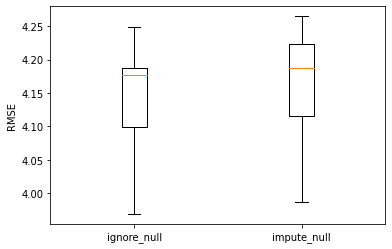

In [ ]:
# plt.boxplot([cvscores_ignore_null,cvscores_impute_null], labels=['ignore_null','impute_null'])
# plt.ylabel('RMSE');

**Therefore ignore_null is the strategy to be implemented.**

## Time dependant features

The following are the features that we can derive out of purchase_date, month_lag and first_active_month -

1. Span of activity of the card_id = maximum purchase_date - first_active_month.
2. Monthly transaction data - monthly_avg_txn_count, monthly_std_txn_count, monthly_avg_purchase_amt, monthly_std_purchase_amt.
3. Trends in the purchases - quarterly transaction counts and average purchase_amounts. As shown below, based on the span of time covered in histTxns, this will be from 01 Jan 2017 to 28 Feb 2018.

In [ ]:
histTxns.select(F.max(histTxns.purchase_date).alias('max_date'), F.min(histTxns.purchase_date).alias('min_date')).show()

+-------------------+-------------------+
|           max_date|           min_date|
+-------------------+-------------------+
|2018-02-28 23:59:51|2017-01-01 00:00:08|
+-------------------+-------------------+



### histActivePeriodSpan

Span of period (in days) over which the card_id was used, given the histTxns data.

In [36]:
new_features = spark.sql('''
          select
            t1.*,
            datediff(t6.max_purchase_date, t4.first_active_month) as histActivePeriodSpan
          from
            new_features_view t1

              left join (
                          select
                            t2.card_id,
                            t2.first_active_month
                          from
                            testView t2
                          
                          union

                          select
                            t3.card_id,
                            t3.first_active_month
                          from
                            trainView t3

              ) t4 on t1.card_id = t4.card_id

              left join (
                    select
                      t5.card_id,
                      max(t5.purchase_date) as max_purchase_date
                    from
                      histTxnsView t5
                    group by t5.card_id

              ) t6 on t1.card_id = t6.card_id
            
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
new_features.filter('''
(histActivePeriodSpan IS NULL)
OR (histActivePeriodSpan < 0)
''').show(5)

**So there are two card_ids - C_ID_c40853915f and C_ID_c27b4f80f7 - with an issue.** We investigate as shown below and find the solutions for them.

In [ ]:
train.filter('card_id = "C_ID_c40853915f"').show()  

+------------------+---------------+---------+---------+---------+---------+
|first_active_month|        card_id|feature_1|feature_2|feature_3|   target|
+------------------+---------------+---------+---------+---------+---------+
|        2017-04-01|C_ID_c40853915f|        5|        1|        1|-1.224595|
+------------------+---------------+---------+---------+---------+---------+



In [ ]:
histTxns.filter('card_id = "C_ID_c40853915f"').select(F.min('purchase_date'),F.max('purchase_date')).show()
#  first_active_month for C_ID_c40853915f is greater than minimum purchase_date for C_ID_c40853915f in histTxns
#  Hence we change the first_active month for C_ID_c40853915f to 12 Feb 2017.
#  span = 2017-03-04 - 2017-02-12 = 20

+-------------------+-------------------+
| min(purchase_date)| max(purchase_date)|
+-------------------+-------------------+
|2017-02-12 05:50:36|2017-03-04 07:06:27|
+-------------------+-------------------+



In [ ]:
test.filter('card_id = "C_ID_c27b4f80f7"').show()

+------------------+---------------+---------+---------+---------+
|first_active_month|        card_id|feature_1|feature_2|feature_3|
+------------------+---------------+---------+---------+---------+
|              null|C_ID_c27b4f80f7|        5|        2|        1|
+------------------+---------------+---------+---------+---------+



In [ ]:
histTxns.filter('card_id = "C_ID_c27b4f80f7"').select(F.min('purchase_date'),F.max('purchase_date')).show()
# In test first_active_month for C_ID_c27b4f80f7 is null.
# This is imputed with 09 Mar 2017 - the minimum purchase_date from histTxns.
# span = 2018-02-27 - 2017-03-09 = 355

+-------------------+-------------------+
| min(purchase_date)| max(purchase_date)|
+-------------------+-------------------+
|2017-03-09 01:34:22|2018-02-27 11:10:45|
+-------------------+-------------------+



#### Value correction and null imputation

In [37]:
train = train.withColumn('first_active_month', F.when(train.card_id=='C_ID_c40853915f',datetime.date(2017,2,12))\
                 .otherwise(train.first_active_month))
updateViewAndCache(train,'trainView',updateView=True,doCaching=False)

In [38]:
test = test.withColumn('first_active_month', F.when(test.card_id=='C_ID_c27b4f80f7',datetime.date(2017,3,9))\
                 .otherwise(test.first_active_month))
updateViewAndCache(test,'testView',updateView=True,doCaching=False)

In [37]:
new_features = new_features.withColumn('histActivePeriodSpan', F.when(new_features.card_id=='C_ID_c40853915f',20).\
                                       when(new_features.card_id=='C_ID_c27b4f80f7',355).\
                                       otherwise(new_features.histActivePeriodSpan))
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

### histAvgMonthlyAuthTxnCnt, histStdMonthlyAuthTxnCnt, histAvgMonthlyPurchaseAmt, histStdMonthlyPurchaseAmt

Monthly figures for authorised transactions only.

In [38]:
new_features = spark.sql('''
          select
            t1.*,
            nvl(t4.histAvgMonthlyAuthTxnCnt,0) as histAvgMonthlyAuthTxnCnt,
            nvl(t4.histStdMonthlyAuthTxnCnt,0) as histStdMonthlyAuthTxnCnt,
            nvl(t4.histAvgMonthlyPurchaseAmt,0) as histAvgMonthlyPurchaseAmt,
            nvl(t4.histStdMonthlyPurchaseAmt,0) as histStdMonthlyPurchaseAmt
          from
            new_features_view t1

              left join (
                select
                  t3.card_id,
                  avg(t3.monthly_txn_count) as histAvgMonthlyAuthTxnCnt,
                  stddev(t3.monthly_txn_count) as histStdMonthlyAuthTxnCnt,
                  avg(t3.monthly_purchase_amt) as histAvgMonthlyPurchaseAmt,
                  stddev(t3.monthly_purchase_amt) as histStdMonthlyPurchaseAmt
                from
                (
                  select 
                    t2.card_id,
                    extract(year from t2.purchase_date) year,
                    extract(month from t2.purchase_date) as month_num,
                    count(*) as monthly_txn_count,
                    sum(t2.purchase_amount) as monthly_purchase_amt
                  from
                    histTxnsView t2
                  where t2.authorized_flag = 'Y'
                  group by t2.card_id, extract(year from t2.purchase_date), extract(month from t2.purchase_date)
                ) t3
                group by t3.card_id
              ) t4 on t1.card_id = t4.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

### histAvgMonthlyUnauthTxnCnt, histStdMonthlyUnauthTxnCnt

Monthly unauthorised transaction count

In [39]:
new_features = spark.sql('''
          select
            t1.*,
            nvl(t4.histAvgMonthlyUnauthTxnCnt,0) as histAvgMonthlyUnauthTxnCnt,
            nvl(t4.histStdMonthlyUnauthTxnCnt,0) as histStdMonthlyUnauthTxnCnt
          from
            new_features_view t1

              left join (
                select
                  t3.card_id,
                  avg(t3.monthly_txn_count) as histAvgMonthlyUnauthTxnCnt,
                  stddev(t3.monthly_txn_count) as histStdMonthlyUnauthTxnCnt
                from
                (
                  select 
                    t2.card_id,
                    extract(year from t2.purchase_date) year,
                    extract(month from t2.purchase_date) as month_num,
                    count(*) as monthly_txn_count
                  from
                    histTxnsView t2
                  where t2.authorized_flag = 'N'
                  group by t2.card_id, extract(year from t2.purchase_date), extract(month from t2.purchase_date)
                ) t3
                group by t3.card_id
              ) t4 on t1.card_id = t4.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

### histQ1TxnCnt, histQ2TxnCnt, histQ3TxnCnt, histQ4TxnCnt, histQ5TxnCnt, histQ1PurchaseAmt, histQ2PurchaseAmt, histQ3PurchaseAmt, histQ4PurchaseAmt, histQ5PurchaseAmt

Over authorised transactions only

In [40]:
new_features = spark.sql('''
          with QuarterlyData(card_id, Quarter, quarterly_txn_count, quarterly_purchase_amount) as (
              select
                card_id,
                quarter(purchase_date) + (4*(year(purchase_date) - 2017)),  -- so that Q1 of 2018 gives 5
                /*
                  For 2018 the data is of 2 months only. Hence they are multiplied by 2 
                */
                count(*) * (1 + year(purchase_date) - 2017),
                sum(purchase_amount) * (1 + year(purchase_date) - 2017)
              from
                histTxnsView
              where authorized_flag = 'Y'
              group by card_id, year(purchase_date), quarter(purchase_date)
          )

          select
            t1.*,
            nvl(Q1.quarterly_txn_count,0) as histQ1TxnCnt,
            nvl(Q2.quarterly_txn_count,0) as histQ2TxnCnt,
            nvl(Q3.quarterly_txn_count,0) as histQ3TxnCnt,
            nvl(Q4.quarterly_txn_count,0) as histQ4TxnCnt,
            nvl(Q5.quarterly_txn_count,0) as histQ5TxnCnt,
            nvl(Q1.quarterly_purchase_amount,0) as histQ1PurchaseAmt,
            nvl(Q2.quarterly_purchase_amount,0) as histQ2PurchaseAmt,
            nvl(Q3.quarterly_purchase_amount,0) as histQ3PurchaseAmt,
            nvl(Q4.quarterly_purchase_amount,0) as histQ4PurchaseAmt,
            nvl(Q5.quarterly_purchase_amount,0) as histQ5PurchaseAmt
          from
            new_features_view t1
              left join (select * from QuarterlyData where Quarter=1) Q1 on t1.card_id = Q1.card_id
              left join (select * from QuarterlyData where Quarter=2) Q2 on t1.card_id = Q2.card_id
              left join (select * from QuarterlyData where Quarter=3) Q3 on t1.card_id = Q3.card_id
              left join (select * from QuarterlyData where Quarter=4) Q4 on t1.card_id = Q4.card_id
              left join (select * from QuarterlyData where Quarter=5) Q5 on t1.card_id = Q5.card_id
''')
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=False)

In [ ]:
updateViewAndCache(new_features,'new_features_view',updateView=True,doCaching=True)
# sdf = combine_new_features(train, new_features)
# updateViewAndCache(sdf,updateView=False,doCaching=True)
# pdf = convert_to_pandas(sdf)
# cvscores = np.sqrt(-(pandas_random_forest_regr(pdf)))

In [44]:
print('Completed')

Completed


## Merchant

In [ ]:
spark.sql('''
          select count(distinct merchant_category_id) as noOfDistinctMerchantCategories from histTxnsView
''').show()

In [ ]:
merchant.count()

The data description in kaggle says that the number of unique merchant ids should be 334633; hence a few merchant ids may be present multiple times. We will identify them.

In [ ]:
spark.sql('''
          select
            t1.merchant_id,
            count(*) as CNT
          from
            merchantView t1
          group by t1.merchant_id
          having count(*) > 1
''').count()

There are 41 such merchant_ids. How do these entries differ from each other?

In [ ]:
spark.sql('''
          select
            *
          from
            merchantView t2
          where
            t2.merchant_id in (
                                select
                                  t1.merchant_id
                                from
                                  merchantView t1
                                group by t1.merchant_id
                                having count(*) > 1
                              )
            
          order by t2.merchant_id
''').show(6)

We doubt that the duplicate entries might be due to data collected at different times. Because we see that the time-dependant econimic metrics vary but often the categorical non-economic features- like merchant_group_id, subsector_id etc.- remain same.

Hence we decide to find the duplicate merchant_ids with different "categorical non-economic features" and also what these features are and where the difference is being shown.

In [ ]:
spark.sql('''
          select
            t1.merchant_id,
            grouping(t1.merchant_id) as G_merchant_id,
            grouping(merchant_group_id) as G_merchant_group_id,
            grouping(merchant_category_id)as G_merchant_category_id,
            grouping(subsector_id)as G_subsector_id,
            grouping(category_1)as G_category_1,
            grouping(category_4)as G_category_4,
            grouping(city_id)as G_city_id,
            grouping(state_id)as G_state_id,
            grouping(category_2)as G_category_2,
            count(*) as CNT
          from
            merchantView t1
          where 
            t1.merchant_id in (
              select
                t1.merchant_id
              from
                merchantView t1
              group by t1.merchant_id
              having count(*) > 1
            )
          group by cube(t1.merchant_id,merchant_group_id,merchant_category_id,subsector_id,category_1,category_4,city_id,state_id,category_2)
          having (G_merchant_id = 0 and count(*) > 1)
''').select(F.countDistinct("merchant_id")).show()

All the duplicate merchant_ids have different entries for one or the other categorical non-economic features. Hence we are unable to somehow combine the duplicate entries into a single one for each merchant_id. Instead we have to choose one out of multiple entries for each merchant_id.

At this point we notice one strange point regarding the active_months_lag6 and active_months_lag12 features for the duplicate entries. Say for M_ID_0039220eb3 one entry says active_months_lag6 = 6 and active_months_lag12 = 12 while another entry shows active_months_lag6 = 3, active_months_lag12 = 3. The first entry says the merchant was active throughout the year while the second entry denotes that for the later half of the year the merchant was not active at all. This type of scenario can be an error or maybe the merchant reached near bankruptcy at the end of 6 months but immediately bounced back. Either way the first entry, where active_months_lag12 > active_months_lag6 seems a more acceptable entry. Similarly active_months_lag6 should be greater than active_months_lag3.

This above pattern seems to repeat for some of the duplicate entries. Hence we need to identify those entries where these conditions hold and see how many merchant_ids get covered among the 41 cases.

In [ ]:
spark.sql('''
          select
            *
          from
            merchantView t3
          where t3.merchant_id in (
            select
              t2.merchant_id
            from
              merchantView t2
            where
              t2.merchant_id in (
                                  select
                                    t1.merchant_id
                                  from
                                    merchantView t1
                                  group by t1.merchant_id
                                  having count(*) > 1
                                )
              and t2.active_months_lag6 < t2.active_months_lag12
              and t2.active_months_lag3 < t2.active_months_lag6
              --and t2.avg_sales_lag3 < t2.avg_sales_lag6
              --and t2.avg_purchases_lag3 < t2.avg_purchases_lag6
              --and t2.avg_sales_lag6 < t2.avg_sales_lag12
              --and t2.avg_purchases_lag6 < t2.avg_purchases_lag12
              group by t2.merchant_id
              having count(*) > 1
            --order by t2.merchant_id
          )
          order by t3.merchant_id
''').select(F.countDistinct('merchant_id')).show()

There are still around 30 merchant_ids that show duplicate entries inspite of our contraint regarding the active periods.

In [ ]:
duplicate_merchants = spark.sql('''
          select
            *
          from
            merchantView t3
          where t3.merchant_id in (
            select
              t2.merchant_id
            from
              merchantView t2
            where
              t2.merchant_id in (
                                  select
                                    t1.merchant_id
                                  from
                                    merchantView t1
                                  group by t1.merchant_id
                                  having count(*) > 1
                                )
              and t2.active_months_lag6 < t2.active_months_lag12
              and t2.active_months_lag3 < t2.active_months_lag6
              --and t2.avg_sales_lag3 < t2.avg_sales_lag6
              --and t2.avg_purchases_lag3 < t2.avg_purchases_lag6
              --and t2.avg_sales_lag6 < t2.avg_sales_lag12
              --and t2.avg_purchases_lag6 < t2.avg_purchases_lag12
              group by t2.merchant_id
              having count(*) > 1
            --order by t2.merchant_id
          )
          order by t3.merchant_id
''')
updateViewAndCache(duplicate_merchants,viewName='duplicate_merchants_view',updateView=True)

In [ ]:
duplicate_merchants.filter(duplicate_merchants.merchant_id=='M_ID_00a6ca8a8a').show()

In [ ]:
spark.sql('''
          select
            extract(month from t1.purchase_date) as month,
            avg(t1.purchase_amount) as amount
          from
            histTxnsView t1
          where
            t1.merchant_id = 'M_ID_00a6ca8a8a'
            and t1.authorized_flag = 'Y'
          group by extract(month from t1.purchase_date)
          order by month
''').show()

In [ ]:
spark.sql('''
          select
            min(t1.purchase_date),
            max(t1.purchase_date)
          from
            histTxnsView t1
          where
            t1.merchant_id = 'M_ID_00a6ca8a8a'
            and t1.authorized_flag = 'Y'
          --group by extract(month from t1.purchase_date)
          --order by month
''').show()